<a href="https://colab.research.google.com/github/nakuluttarkar/cifar10-pytorch-image-classifier/blob/main/cifar10_pytorch_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib tqdm --quiet

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2470, 0.2435, 0.2616]

In [31]:
# """Training Dataset"""
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # add a 4px border, then take a 32x32 crop at a random spot
    transforms.RandomHorizontalFlip(),      # flip left-right with 50% chance (Data Augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # small changes in colors
    transforms.ToTensor(),                  # HxWxC [0..255] → CxHxW [0..1] float tensor
    transforms.Normalize(cifar10_mean, cifar10_std), # per-channel standardization
])


In [10]:
# """Test Dataset"""
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])
# """No Data augmentation"""

In [32]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)


In [ ]:
classes = train_dataset.classes
print("Classes:", classes)

# ==============================
# Define Model (Simple CNN)
# ==============================

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8 -> 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print(model)


# Loss & Optimizer

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Training & Validation Loops

In [36]:
def train_one_epoch(model, dataloader, criterion, optimizer):
  model.train()
  total_loss, correct, total = 0, 0, 0
  for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    logits = model(inputs)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, preds = logits.max(dim=1) # Specify dim=1 to get max along the class dimension
    total += labels.size(0)
    correct += preds.eq(labels).sum().item()

  return total_loss / total, 100. * correct / total

In [41]:
def evaluate(model, dataloader, criterion):
  model.eval()
  total_loss, correct, total = 0, 0, 0
  with torch.no_grad():
      loop = tqdm(dataloader, desc="Validating", leave=False)
      for images, labels in loop:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)

          total_loss += loss.item() * images.size(0)
          _, preds = outputs.max(1)
          total += labels.size(0)
          correct += preds.eq(labels).sum().item()
  return total_loss/total, 100.*correct/total

# Run Training

In [ ]:
num_epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, \nVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")

# Plot Training Curves

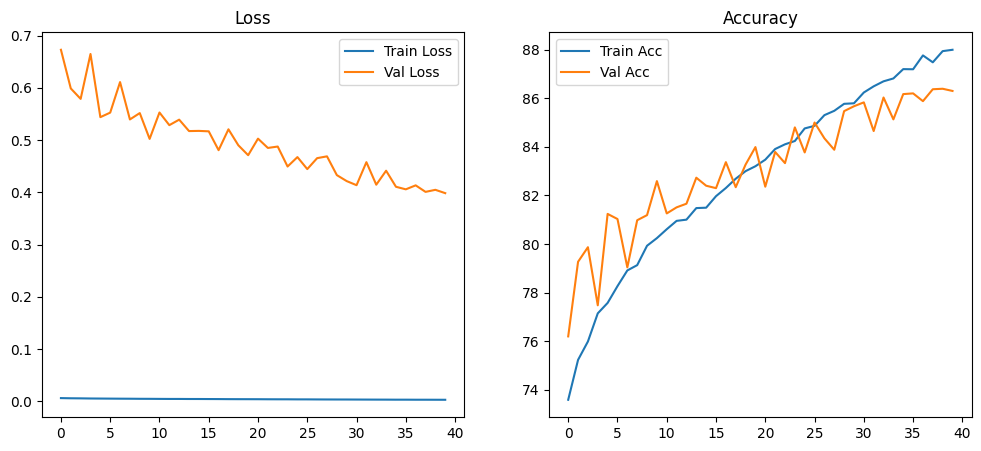

In [43]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.show()



# Visualize Predictions

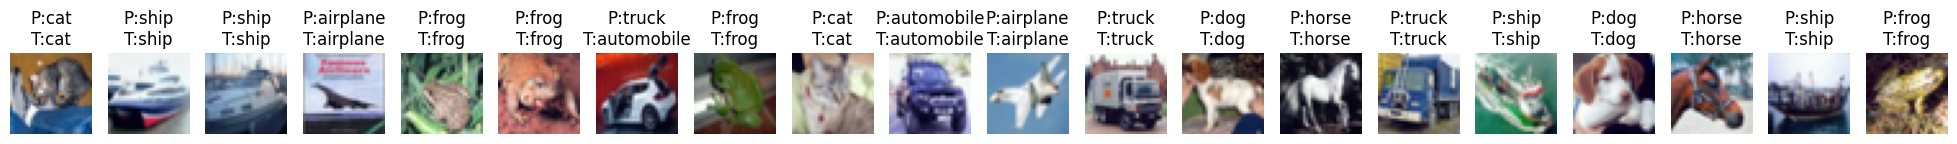

In [44]:
def show_predictions(model, dataloader, classes, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(25,25))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().permute(1,2,0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # un-normalize for display
                plt.subplot(1, num_images, images_shown+1)
                plt.imshow(img)
                plt.title(f"P:{classes[preds[i]]}\nT:{classes[labels[i]]}")
                plt.axis("off")
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

show_predictions(model, test_loader, classes, num_images=20)